### test

In [428]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn

In [423]:
%matplotlib inline

In [424]:
from matplotlib import rcParams
rcParams['figure.figsize'] = [18, 8]

In [425]:
# cpu_use_p = np.random.dirichlet(np.ones(100), size=1).reshape(100)

######################################

https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [426]:
# n = 120
# cpu_arr = np.cumsum(np.random.randn(n)) / np.sqrt(n)
# cpu_arr = cpu_arr / cpu_arr.max()

In [437]:
training_set = pd.read_csv('airline-passengers.csv')
training_set = training_set.iloc[:,1:2].values

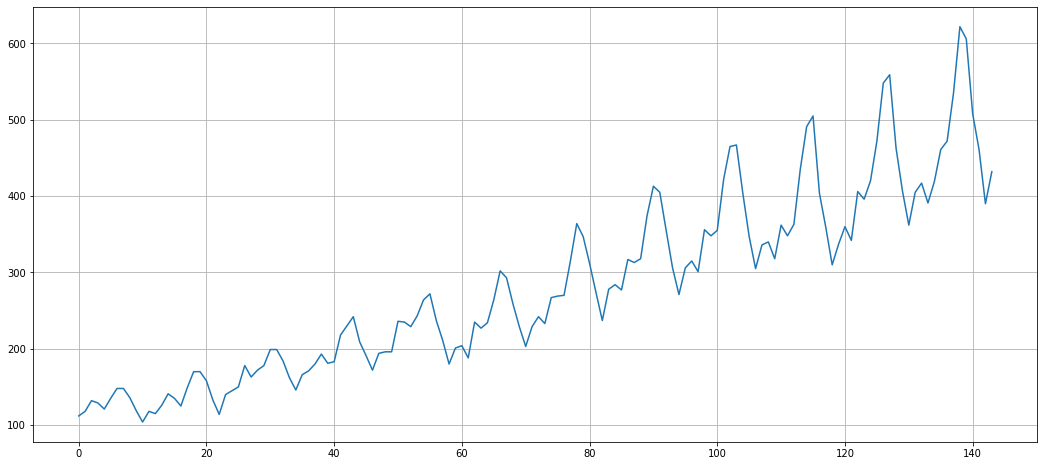

In [438]:
plt.grid(True)
plt.plot(training_set)

In [439]:
test_data_size = 12

In [440]:
train_data = training_set[:-test_data_size]
test_data = training_set[-test_data_size:]

In [441]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
train_data_normalized = train_data

In [442]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [443]:
train_window = 12

In [444]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [445]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [446]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [447]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [448]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 145626.09375000
epoch:  26 loss: 52069.75781250
epoch:  51 loss: 37315.75000000
epoch:  76 loss: 20896.92187500
epoch: 101 loss: 9095.17382812
epoch: 126 loss: 6614.96386719
epoch: 149 loss: 2160.4140625000


In [449]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()

In [450]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [451]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))

In [452]:
x = np.arange(108, 120, 1)

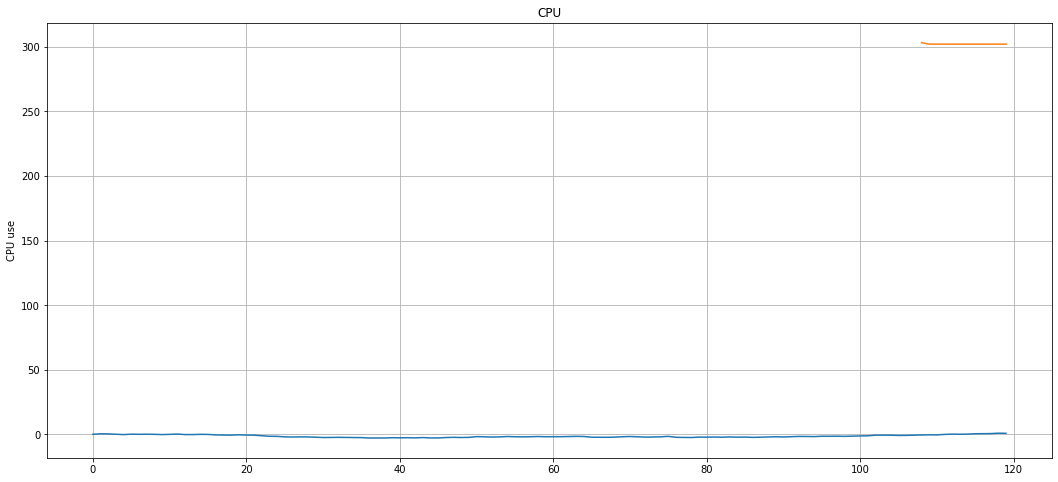

In [453]:
plt.title('CPU')
plt.ylabel('CPU use')
plt.grid(True)
# plt.autoscale(axis='x', tight=True)
plt.plot(cpu_arr)
plt.plot(x, actual_predictions)
plt.show()